<a href="https://colab.research.google.com/github/jiin124/Introduction-to-NLP-using-deep-learning/blob/main/%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D/7_%EB%AC%B8%EC%9E%90%EB%8B%A8%EC%9C%84_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

지금까지 다룬 RNN은 입력과 출력의 단위가 단어벡터였다. 하지만 입출력의 단위를 단어레벨에서 문자 레벨로 변경해 rnn을 구성할 수 있다. 

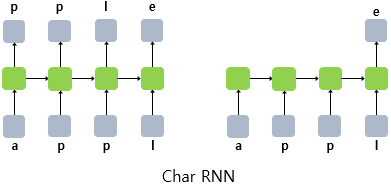

# 1. 문자 단위 RNN 언어 모델(Char RNNLM)

다운로드 링크 : http://www.gutenberg.org/files/11/11-0.txt

## 1) 데이터에 대한 이해와 전처리

In [1]:
import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical

urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")

f=open('11-0.txt','rb')
sentences=[]
for sentence in f:# 데이터로부터 한 줄씩 읽는다.
  sentence=sentence.strip()# strip()을 통해 \r, \n을 제거한다.
  sentence=sentence.lower() # 소문자화.
  sentence=sentence.decode('ascii','ignore') # \xe2\x80\x99 등과 같은 바이트 열 제거
  if len(sentence)>0:
    sentences.append(sentence)
f.close()

In [2]:
sentences[:5]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. you may copy it, give it away or re-use it under the terms',
 'of the project gutenberg license included with this ebook or online at']

리스트의 원소는 문자열로 구성되어져있는데 의미있고 문장 토큰화가 된 상태는 아니다. 이를 하나의 문자열로 통합

In [3]:
total_data=' '.join(sentences)
print('문자열의 길이 또는 총 문자의 개수: %d'%len(total_data))

문자열의 길이 또는 총 문자의 개수: 159484


In [4]:
print(total_data[:200])

the project gutenberg ebook of alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with


이 문자열로부터 문자 집합을 만들겠다. 기존에는 중복을 제거한 단어들의 모음인 단어 집합을 만들었으니 이번에 만들 집합은 단어 집합이 아니라 문자 집합니다. 

In [6]:
char_vocab=sorted(list(set(total_data)))
vocab_size=len(char_vocab)
print('문자 집합의 크기 : {}'.format(vocab_size))

문자 집합의 크기 : 56


영어가 훈련데이터일떄 문자 집합의 크기는 단어 집합을 사용했을 경우보다 집합의 크기가 현저히 작다. 아무리 훈련 코퍼스에 수십만 개 이상의 많은 영어 단어가 존재한다고 해도 영어 단어를 표현하기 위해서 사용되는 문자는 26개의 알파벳뿐이기 떄문이다. 만약 훈련데이터의 알파벳이 대 소문자가 구분된 상태라고 하더라고 모든 영어 단어는 총 52개의 알파벳으로표현가능

In [7]:
#문자에 고유한 정수 부여
char_to_index=dict((char,index) for index, char in enumerate(char_vocab))
print('문자 집합 :',char_to_index)

문자 집합 : {' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, '[': 27, ']': 28, '_': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55}


정수 0부터 28까지는 공백을 포함한 각종 구두점, 특수문자가 존재하고, 정수 29부터 54까지는 a부터 z까지 총 26개의 알파벳 소문자가 문자 집합에 포함되어져 있습니다. 반대로 정수로부터 문자를 리턴하는 index_to_char을 만듭니다

In [8]:
index_to_char={}
for key,value in char_to_index.items():
  index_to_char[value]=key

훈련데이터를 구성. 훈련데이터에 apple이라는 시퀀스가 있고 입력의 길이를 4라고 정했을 때 데이터의 구성은 어떻게 될까? 입력의 길이가 4이므로 입력 시퀀스와 예측해야 하는 출력 시퀀스 모두 길이는 4가 된다. 다시 말해 RNN은 총 4번의 시점을 가질 수 있다는 의미이다. apple은 다섯글자이지만 입력의 길이는 4이므로 'appl'까지만 입력으로 사용할 수 있다. 그리고 언어모델은 다음시점의 입력을 예측해야하는 모델이므로 'pple'을 예측하도록 데이터가 구성

In [10]:
train_X='appl'
train_y='pple'

이제 15만 9천의 길이를 가진 문자열로부터 다수의 샘플들을 만들어보겠습니다. 데이터를 만드는 방법은 문장 샘플의 길이를 정하고, 해당 길이만큼 문자열 전체를 등분하는 것입니다. 여기서는 문장의 길이를 60으로 정했는데, 결국 15만 9천을 60으로 나눈 수가 샘플의 수가 됩니다. 몇 개의 샘플을 만들 수 있을지 그 개수를 계산해봅시다.

In [11]:
seq_length=60

#문자열의 길이를 seq_length로 나누면 전처리 후 생겨날 샘플수
n_samples=int(np.floor((len(total_data)-1)/seq_length))
print('샘플의 수 : {}'.format(n_samples))

샘플의 수 : 2658


In [12]:
train_X=[]
train_y=[]

for i in range(n_samples):
   # 0:60 -> 60:120 -> 120:180로 loop를 돌면서 문장 샘플을 1개씩 pick.
  X_sample=total_data[i*seq_length:(i+1)*seq_length]

  #정수인코딩
  X_encoded=[char_to_index[c] for c in X_sample]
  train_X.append(X_encoded)

  #오른쪽으로 1칸 쉬프트
  y_sample=total_data[i*seq_length+1:(i+1)*seq_length+1]
  y_encoded=[char_to_index[c] for c in y_sample]
  train_y.append(y_encoded)

In [13]:
print('X 데이터의 첫번째 샘플 :',train_X[0])
print('y 데이터의 첫번째 샘플 :',train_y[0])
print('-'*50)
print('X 데이터의 첫번째 샘플 디코딩 :',[index_to_char[i] for i in train_X[0]])
print('y 데이터의 첫번째 샘플 디코딩 :',[index_to_char[i] for i in train_y[0]])

X 데이터의 첫번째 샘플 : [49, 37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30]
y 데이터의 첫번째 샘플 : [37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30, 43]
--------------------------------------------------
X 데이터의 첫번째 샘플 디코딩 : ['t', 'h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 'e', 'b', 'o', 'o', 'k', ' ', 'o', 'f', ' ', 'a', 'l', 'i', 'c', 'e', 's', ' ', 'a', 'd', 'v', 'e', 'n', 't', 'u', 'r', 'e', 's', ' ', 'i', 'n', ' ', 'w', 'o', 'n', 'd', 'e', 'r', 'l', 'a']
y 데이터의 첫번째 샘플 디코딩 : ['h', 'e', ' ', 'p', 'r', 'o', 'j', 'e', 'c', 't', ' ', 'g', 'u', 't', 'e', 'n', 'b', 'e', 'r', 'g', ' ', 'e',

train_y[0]은 train_X[0]에서 오른쪽으로 한 칸 쉬프트 된 문장임을 알 수 있습니다. train_X와 train_y의 두번째 샘플. 즉, 인덱스가 1번인 샘플을 출력하여 데이터의 구성을 확인해봅시다.

In [14]:
print(train_X[1])

[43, 33, 10, 0, 31, 54, 0, 41, 34, 52, 38, 48, 0, 32, 30, 47, 47, 44, 41, 41, 0, 49, 37, 38, 48, 0, 34, 31, 44, 44, 40, 0, 38, 48, 0, 35, 44, 47, 0, 49, 37, 34, 0, 50, 48, 34, 0, 44, 35, 0, 30, 43, 54, 44, 43, 34, 0, 30, 43, 54]


In [15]:
print(train_y[1])

[33, 10, 0, 31, 54, 0, 41, 34, 52, 38, 48, 0, 32, 30, 47, 47, 44, 41, 41, 0, 49, 37, 38, 48, 0, 34, 31, 44, 44, 40, 0, 38, 48, 0, 35, 44, 47, 0, 49, 37, 34, 0, 50, 48, 34, 0, 44, 35, 0, 30, 43, 54, 44, 43, 34, 0, 30, 43, 54, 52]


train_x와 train_y에 대해서 원-핫인코딩을 수행한다. 문자 단위 RNN에서는 입력 시퀀스에 대해서 워드 임베딩을 하지 않는다. 다시 말해 임베딩층을 사용하지 않을 것이므로 입력 시퀀스인 train_X에 대해서도 원-핫 인코딩을 한다. 

In [16]:
train_X=to_categorical(train_X)
train_y=to_categorical(train_y)

print('train_X의 크기(shape) : {}'.format(train_X.shape)) # 원-핫 인코딩
print('train_y의 크기(shape) : {}'.format(train_y.shape)) # 원-핫 인코딩

train_X의 크기(shape) : (2658, 60, 56)
train_y의 크기(shape) : (2658, 60, 56)


이는 샘플의 수(No. of samples)가 2,658개, 입력 시퀀스의 길이(input_length)가 60, 각 벡터의 차원(input_dim)이 55임을 의미합니다. 원-핫 벡터의 차원은 문자 집합의 크기인 56이어야 하므로 원-핫 인코딩이 수행되었음을 알 수 있습니다.

## 2) 모델 설계하기

하이퍼파라미터인 은닉 상태의 크기는 256입니다. 모델은 다 대 다 구조의 LSTM을 사용하며, LSTM 은닉층은 두 개를 사용합니다. 전결합층(Fully Connected Layer)을 출력층으로 문자 집합 크기만큼의 뉴런을 배치하여 모델을 설계합니다. 해당 모델은 모든 시점에서 모든 가능한 문자 중 하나의 문자를 예측하는 다중 클래스 분류 문제를 수행하는 모델입니다. 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용하여 80 에포크를 수행합니다.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,TimeDistributed

hidden_units=256

model=Sequential()
model.add(LSTM(hidden_units,input_shape=(None,train_X.shape[2]),return_sequences=True))
model.add(LSTM(hidden_units,return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size,activation='softmax')))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(train_X,train_y,epochs=80,verbose=2)

Epoch 1/80
84/84 - 55s - loss: 3.0676 - accuracy: 0.1840 - 55s/epoch - 656ms/step
Epoch 2/80
84/84 - 52s - loss: 2.7525 - accuracy: 0.2447 - 52s/epoch - 624ms/step
Epoch 3/80
84/84 - 50s - loss: 2.4049 - accuracy: 0.3266 - 50s/epoch - 595ms/step
Epoch 4/80
84/84 - 49s - loss: 2.2632 - accuracy: 0.3585 - 49s/epoch - 578ms/step
Epoch 5/80
84/84 - 47s - loss: 2.1682 - accuracy: 0.3834 - 47s/epoch - 558ms/step
Epoch 6/80
84/84 - 49s - loss: 2.0832 - accuracy: 0.4026 - 49s/epoch - 579ms/step
Epoch 7/80
84/84 - 51s - loss: 2.0179 - accuracy: 0.4191 - 51s/epoch - 613ms/step
Epoch 8/80
84/84 - 49s - loss: 1.9626 - accuracy: 0.4337 - 49s/epoch - 579ms/step
Epoch 9/80
84/84 - 48s - loss: 1.9129 - accuracy: 0.4482 - 48s/epoch - 577ms/step
Epoch 10/80
84/84 - 48s - loss: 1.8649 - accuracy: 0.4600 - 48s/epoch - 570ms/step
Epoch 11/80
84/84 - 50s - loss: 1.8243 - accuracy: 0.4720 - 50s/epoch - 599ms/step
Epoch 12/80
84/84 - 50s - loss: 1.7853 - accuracy: 0.4822 - 50s/epoch - 591ms/step
Epoch 13/80
8

In [19]:
def sentence_generation(model,length):
  #문자에 대한 랜덤한 정수 생성
  ix=[np.random.randint(vocab_size)]

  #랜덤한 정수로부터 맵핑되는 문자 생성
  y_char=[index_to_char[ix[-1]]]
  print(ix[-1],'번 문자',y_char[-1],'로 예측을 시작!')

  #(1,length,55)크기의 X생성, 즉 LSTM의 입력 시퀀스 생성
  X=np.zeros((1,length,vocab_size))

  for i in range(length):
    # X[0][i][예측한 문자의 인덱스] = 1, 즉, 예측 문자를 다음 입력 시퀀스에 추가
    X[0][i][ix[-1]] = 1
    print(index_to_char[ix[-1]], end="")
    ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
    y_char.append(index_to_char[ix[-1]])
  return ('').join(y_char)

In [20]:
result = sentence_generation(model, 100)
print(result)

26 번 문자 ? 로 예측을 시작!
? she said to herself, and she said to herself, and ive tried he was of the woods with a thing, said? she said to herself, and she said to herself, and ive tried he was of the woods with a thing, said 


# 2. 문자단위 RNN(Char RNN)으로 텍스트 생성

이번에는 다대일구조의 RNN을 문자 단위로 학습시키고 텍스트 생성

In [21]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [22]:
raw_text = '''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''

In [23]:
tokens=raw_text.split()
raw_text=' '.join(tokens)
print(raw_text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


In [25]:
# 중복을 제거한 문자 집합 생성
char_vocab=sorted(list(set(raw_text)))
vocab_size=len(char_vocab)
print('문자집합 :',char_vocab)
print('문자 집합의 크기 : {}'.format(vocab_size))

문자집합 : [' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']
문자 집합의 크기 : 33


In [26]:
char_to_index=dict((char,index) for index,char in enumerate(char_vocab))
print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


여기서는 입력 시퀀스의 길이가 10가 되도록 데이터를 구성하겠습니다. 예측 대상인 문자도 필요하므로 길이가 11이 되도록 데이터를 구성합니다.

In [28]:
length=11

sequences=[]
for i in range(length,len(raw_text)):
  seq=raw_text[i-length:i]# 길이 11의 문자열을 지속적으로 만든다.
  sequences.append(seq)
print('총 훈련 샘플의 수: %d'%len(sequences))

총 훈련 샘플의 수: 426


In [29]:
sequences[:10]

['I get on wi',
 ' get on wit',
 'get on with',
 'et on with ',
 't on with l',
 ' on with li',
 'on with lif',
 'n with life',
 ' with life ',
 'with life a']

In [30]:
encoded_sequences=[]

for sequence in sequences:
  #전체 데이터에서 문장 샘플을 1개씩 꺼냄
  encoded_sequence=[char_to_index[char] for char in sequence]
  encoded_sequences.append(encoded_sequence)

In [31]:
encoded_sequences[:5]

[[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18],
 [0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28],
 [16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17],
 [14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0],
 [28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]]

예측 대상인 문자를 분리시켜주는 작업을 해봅시다. 모든 샘플 문장에 대해서 마지막 문자를 분리하여 마지막 문자가 분리된 샘플은 X_data에 저장하고, 마지막 문자는 y_data에 저장합니다.

In [32]:
encoded_sequences = np.array(encoded_sequences)

# 맨 마지막 위치의 문자를 분리
X_data = encoded_sequences[:,:-1]
# 맨 마지막 위치의 문자를 저장
y_data = encoded_sequences[:,-1]

이제 X와 y에 대해서 원-핫 인코딩을 수행해보겠습니다.

In [33]:
# 원-핫 인코딩
X_data_one_hot = [to_categorical(encoded, num_classes=vocab_size) for encoded in X_data]
X_data_one_hot = np.array(X_data_one_hot)
y_data_one_hot = to_categorical(y_data, num_classes=vocab_size)

In [34]:
print(X_data_one_hot.shape)

(426, 10, 33)


샘플의 수(No. of samples)가 426개, 입력 시퀀스의 길이(input_length)가 10, 각 벡터의 차원(input_dim)이 33임을 의미합니다

### 2) 모델설계

하이퍼파라미터인 은닉 상태의 크기는 64입니다. 모델은 다 대 일 구조의 LSTM을 사용합니다. 전결합층(Fully Connected Layer)을 출력층으로 문자 집합 크기만큼의 뉴런을 배치하여 모델을 설계합니다. 해당 모델은 마지막 시점에서 모든 가능한 문자 중 하나의 문자를 예측하는 다중 클래스 분류 문제를 수행하는 모델입니다. 다중 클래스 분류 문제의 경우, 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용하여 100 에포크를 수행합니다.

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

hidden_units = 64

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(X_data_one_hot.shape[1], X_data_one_hot.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_data_one_hot, y_data_one_hot, epochs=100, verbose=2)

Epoch 1/100
14/14 - 2s - loss: 3.4593 - accuracy: 0.1080 - 2s/epoch - 149ms/step
Epoch 2/100
14/14 - 0s - loss: 3.3338 - accuracy: 0.1948 - 90ms/epoch - 6ms/step
Epoch 3/100
14/14 - 0s - loss: 3.0690 - accuracy: 0.1972 - 91ms/epoch - 7ms/step
Epoch 4/100
14/14 - 0s - loss: 2.9900 - accuracy: 0.1972 - 102ms/epoch - 7ms/step
Epoch 5/100
14/14 - 0s - loss: 2.9564 - accuracy: 0.1972 - 114ms/epoch - 8ms/step
Epoch 6/100
14/14 - 0s - loss: 2.9342 - accuracy: 0.1972 - 109ms/epoch - 8ms/step
Epoch 7/100
14/14 - 0s - loss: 2.9225 - accuracy: 0.1972 - 105ms/epoch - 8ms/step
Epoch 8/100
14/14 - 0s - loss: 2.9089 - accuracy: 0.1972 - 99ms/epoch - 7ms/step
Epoch 9/100
14/14 - 0s - loss: 2.8938 - accuracy: 0.1972 - 105ms/epoch - 7ms/step
Epoch 10/100
14/14 - 0s - loss: 2.8686 - accuracy: 0.1972 - 99ms/epoch - 7ms/step
Epoch 11/100
14/14 - 0s - loss: 2.8531 - accuracy: 0.1972 - 104ms/epoch - 7ms/step
Epoch 12/100
14/14 - 0s - loss: 2.8291 - accuracy: 0.1972 - 99ms/epoch - 7ms/step
Epoch 13/100
14/14 

In [38]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):

    # 초기 시퀀스
    init_text = seed_text
    sentence = ''

    # 다음 문자 예측은 총 n번만 반복.
    for _ in range(n):
        encoded = [char_to_index[char] for char in seed_text] # 현재 시퀀스에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre') # 데이터에 대한 패딩
        encoded = to_categorical(encoded, num_classes=len(char_to_index))

        # 입력한 X(현재 시퀀스)에 대해서 y를 예측하고 y(예측한 문자)를 result에 저장.
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)

        for char, index in char_to_index.items():
            if index == result:
                break

        # 현재 시퀀스 + 예측 문자를 현재 시퀀스로 변경
        seed_text = seed_text + char

        # 예측 문자를 문장에 저장
        sentence = sentence + char

    # n번의 다음 문자 예측이 끝나면 최종 완성된 문장을 리턴.
    sentence = init_text + sentence
    return sentence

In [39]:
print(sentence_generation(model, char_to_index, 10, 'I get on w', 80))

I get on with life as a programmer, I like to csntemamaaprrnn.... t th bee ? ? loe  oin  m
